# 2 Option pricing using different techniques
### - Compare the performance of option pricing with Monte Carlo simulation of a geometric Brownian motion and with a binary tree. 
 - To get a realistic input value for the volatility, estimate it from (a) historical stock data or (b) from option prices. 
 - Take data for some stock from yahoo or any other source. Indicate clearly in the documentation which date and which underlying you use. Include the code and the data for the estimation of the implied volatility in your project.

### - Price a plain vanilla European option, produce the Greeks and least two of the following options: Corridor, knock-in, knock-out, American, Asian, digital option, Bermuda, Quanto. Try to price an American digital option. Discuss the results.
Note: not all options can be priced equally well with a Monte Carlo and a binary tree. Briefly discuss why in your report.


In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math
from itertools import permutations
from itertools import product
import datetime
import yfinance as yf
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression


In [2]:
start_date=datetime.datetime(2017,11,28)
end_date=datetime.datetime(2023,11,28)
tickers = 'TSLA'
pricesTSLA = yf.download(tickers, start=start_date, end=end_date)
tickers2='PFE'
pricesPFE = yf.download(tickers2, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
historicalTSLA = pricesTSLA['Adj Close'].dropna(how='all')
historicalPFE = pricesPFE['Adj Close'].dropna(how='all')

##### This line selects the 'Adjusted Close' prices from a dataset (prices) and removes any rows where all elements are missing (NaNs).

In [4]:
retTSLA = historicalTSLA.pct_change()[1:]
retPFE=historicalPFE.pct_change()[1:]
lenght=len(retTSLA)
print('The number of observation is',lenght)

The number of observation is 1508


##### Calculates the percentage change in the adjusted close prices, which gives daily returns. The [1:] slices the data to remove the first element since the percentage change for the first day is undefined (NaN).

In [5]:
sample_mean_tsla = np.mean(retTSLA)
vol_tsla = np.std(retTSLA, ddof=1) 
S0_TSLA = historicalTSLA.iloc[-1] #Last price very important in any stochastic process (starting point) 
print('The mean of the returns on the Tesla stock is:',sample_mean_tsla)
print('The volatility of the returns on the Tesla stock is:',vol_tsla)
print('The starting price of the Tesla stock in our processes:',S0_TSLA)


The mean of the returns on the Tesla stock is: 0.0024043663221886644
The volatility of the returns on the Tesla stock is: 0.040156388904390154
The starting price of the Tesla stock in our processes: 236.0800018310547


In [6]:
sample_mean_pfe = np.mean(retPFE)
vol_pfe = np.std(retPFE, ddof=1) 
S0_PFE = historicalPFE.iloc[-1] #Last price very important in any stochastic process (starting point) 
print('The mean of the returns on the Pfizer stock is:',sample_mean_pfe)
print('The volatility of the returns on the Pfizer stock is:',vol_pfe)
print('The starting price of the Pfizer stock in our processes:',S0_PFE)

The mean of the returns on the Pfizer stock is: 0.00019770728308334798
The volatility of the returns on the Pfizer stock is: 0.016010370484271647
The starting price of the Pfizer stock in our processes: 30.139999389648438


## Parameters 
##### Modify the parameter to fit the macroeconomic context and to tailor your option

In [7]:
num_simulations = M = 10000 #Number of Monte Carlo simulations, Higher number = Higher Precision = Higher Processing Power Needed 
r = 0.0537  #Inverted Yield Curve US Treasury yield
T = 1  #Time to expiration (in years), can be modified

## Plain Vanilla European Option

### Monte Carlo Simulation GBM

In [8]:
def monte_carlo_option_price(S, K, r, T, vol, M,opttype):
    
    np.random.seed(23) #We fix our values as we want to discuss them
    dt = 1/252  #Time step, assuming 252 trading days
    num_days = int(T * 252)  #Number of days until expiration

    simulated_prices = np.zeros((num_simulations, num_days)) 
    #A matrix to store simulated stock prices for each simulation across each day. Dim = 1000*252
    for i in range(num_simulations):
        price_path = np.zeros(num_days )
        price_path[0] = S
    #For each simulation (i), it creates a price path (price_path) for the underlying asset over time.
        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_t = price_path[day - 1] * np.exp(drift + diffusion)
            price_path[day] = price_t
    
        simulated_prices[i, :] = price_path
    #Stores the simulated price path in the matrix.

    if opttype.lower() == 'call':
        
        option_payoffs = np.maximum(simulated_prices[:, -1] - K, 0)  # Payoff for call option at expiration
    elif opttype.lower() == 'put':
    
        option_payoffs = np.maximum(K - simulated_prices[:, -1], 0)  # Payoff for put option at expiration
    else:
        raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")
    option_price = np.exp(-r * T) * np.mean(option_payoffs)
    #Calculates the present value of the average payoff, which is the estimated option price.

    return option_price, simulated_prices

In [9]:
option_priceTSLA, price_paths = monte_carlo_option_price(S0_TSLA, 260, r, T, vol_tsla, M,'call') 
print("The price of the Tesla European option is:", option_priceTSLA, "$") 

The price of the Tesla European option is: 0.702158005186093 $


In [10]:
option_pricePFE, _ = monte_carlo_option_price(S0_PFE, 40, r, T, vol_pfe, M,'put') 
print("The price of the Pfizer European option is:", option_pricePFE, "$") 

The price of the Pfizer European option is: 7.771287417661715 $


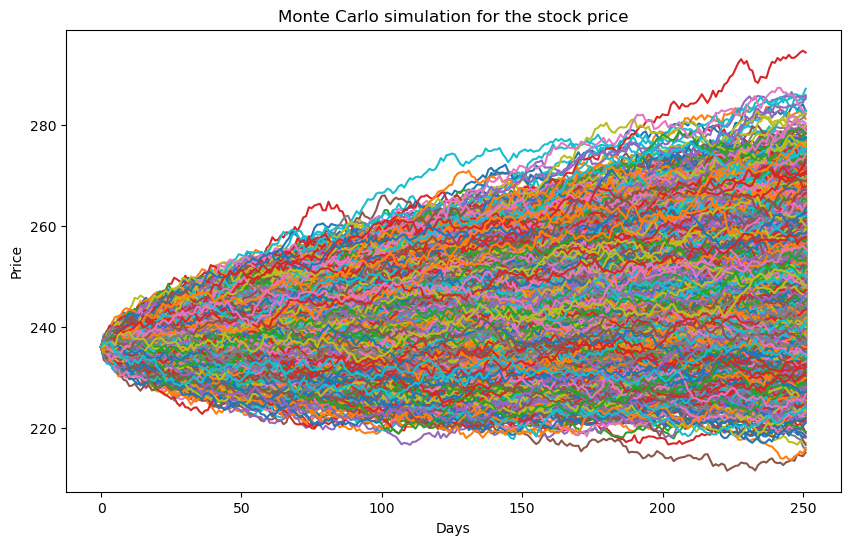

In [11]:
plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    plt.plot(price_paths[i, :], label=f'Simulazione {i + 1}')

plt.title('Monte Carlo simulation for the stock price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

#### Greeks for this option

In [12]:
def calculate_european_greeks(S, K, r, T, vol, M, opttype,greek):
    # Define the small changes for each Greek calculation
    np.random.seed(23) #We fix our values as we want to discuss them
    delta_S = 0.01 * S
    delta_vol = 0.01 * vol
    delta_T = 1 / 252
    delta_r = 0.01

    # Calculate the base option price
    base_price, _ = monte_carlo_option_price(S, K, r, T, vol, num_simulations, opttype)

    # Delta
    if greek == 'delta':
        price_up, _ = monte_carlo_option_price(S + delta_S, K, r, T, vol, num_simulations, opttype)
        greek_value = (price_up - base_price) / delta_S

    # Vega
    elif greek == 'vega':
        price_vol_up, _ = monte_carlo_option_price(S, K, r, T, vol + delta_vol, num_simulations, opttype)
        greek_value = (price_vol_up - base_price) / delta_vol

    # Theta
    elif greek == 'theta':
        price_later, _ = monte_carlo_option_price(S, K, r, T + delta_T, vol, num_simulations, opttype)
        greek_value = (base_price - price_later) / delta_T  

    # Gamma
    elif greek == 'gamma':
        price_up, _ = monte_carlo_option_price(S + delta_S, K, r, T, vol, num_simulations, opttype)
        price_down, _ = monte_carlo_option_price(S - delta_S, K, r, T, vol, num_simulations, opttype)
        delta_up = (price_up - base_price) / delta_S
        delta_down = (base_price - price_down) / delta_S
        greek_value = (delta_up - delta_down) / (2 * delta_S)

    return greek_value



In [13]:
# Calculate and print all the Greeks
greeks_to_calculate = ['delta', 'vega', 'theta', 'gamma']
for greek in greeks_to_calculate:
    np.random.seed(23) #We fix our values as we want to discuss them
    greek_value = calculate_european_greeks(S0_TSLA, 260, r, T, vol_tsla, M,'call', greek)
    print(f"{greek.capitalize()} of the Tesla European option: {greek_value}")

Delta of the Tesla European option: 0.17747429391305314
Vega of the Tesla European option: 54.588963012310316
Theta of the Tesla European option: -1.4540199946155163
Gamma of the Tesla European option: 0.012170058041032676


In [14]:
for greek in greeks_to_calculate:
    np.random.seed(23) #We fix our values as we want to discuss them
    greek_value = calculate_european_greeks(S0_PFE, 40, r, T, vol_pfe, M, 'put', greek)
    print(f"{greek.capitalize()} of the Pfizer European option: {greek_value}")

Delta of the Pfizer European option: -0.9999126855851047
Vega of the Pfizer European option: -0.2352296703772424
Theta of the Pfizer European option: 2.040560026760165
Gamma of the Pfizer European option: -4.788619645786723e-15


### Binary Tree 

In [15]:
N = 36# Number of Steps of the binomial tree, it could be changed.

In [16]:
def binomial_tree_european(S0,K,r,T,vol,N,opttype='call'):
    #precompute constants
    dt = T/N
    u = np.exp(vol * np.sqrt(dt)) #Cox, Ross and Rubinstein (CRR)
    d = 1/u
    q = (np.exp(r*dt) - d) / (u-d)
    disc = np.exp(-r*dt)

    # initialise asset prices at maturity - Time step N
    S = np.zeros(N+1)
    S[0] = S0*d**N #you are taking the worst scenario 
    for j in range(1,N+1):
        S[j] = S[j-1]*u/d  # zig zag at time T to obtain all the prices at the maturity

    # initialise option values at maturity
    C = np.zeros(N+1)
    for j in range(0,N+1):
        if opttype.lower() == 'put':
            C[j] = max(0, K - S[j])
        elif opttype.lower()=='call':
            C[j] = max(0, S[j] - K)
        else:
            raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")

       
    # step backwards through tree
    for i in np.arange(N,0,-1):
        for j in range(0,i):
            C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )

    return C[0]

In [17]:
print("Price of the Tesla European option:",binomial_tree_european(S0_TSLA,260,r,T,vol_tsla,N,opttype='call'),"$") # Choose call or put here

Price of the Tesla European option: 0.6240785581969629 $


In [18]:
print("Price of the Pfizer European option:",binomial_tree_european(S0_PFE,40,r,T,vol_pfe,N,opttype='put'),"$") # Choose call or put here

Price of the Pfizer European option: 7.76865576124996 $


In [19]:
def calculate_european_bingreeks(S,K,r,T,vol,N,opttype,greek):
    np.random.seed(23) #We fix our values as we want to discuss them
    # Define the small changes for each Greek calculation
    delta_S = 0.01 * S
    delta_T = 1 / 252
    delta_r = 0.01
    delta_vol = 0.01 * vol
    
    # Calculate the base option price
    base_price = binomial_tree_european(S,K,r,T,vol,N,opttype)

    # Delta
    if greek == 'delta':
        price_up = binomial_tree_european(S + delta_S,K,r,T,vol,N,opttype)
        greek_value = (price_up - base_price) / delta_S

    # Vega
    elif greek == 'vega':
        price_vol_up = binomial_tree_european(S,K,r,T,vol + delta_vol,N,opttype)
        greek_value = (price_vol_up - base_price) / delta_vol

    # Theta
    elif greek == 'theta':
        price_later = binomial_tree_european(S,K,r,T + delta_T,vol,N,opttype)
        greek_value = (base_price - price_later) / delta_T  # Note that theta is often negative

    # Gamma
    elif greek == 'gamma':
        price_up = binomial_tree_european(S + delta_S,K,r,T,vol,N,opttype)
        price_down = binomial_tree_european(S - delta_S,K,r,T,vol,N,opttype)
        delta_up = (price_up - base_price) / delta_S
        delta_down = (base_price - price_down) / delta_S
        greek_value = (delta_up - delta_down) / (2 * delta_S)

    return greek_value


In [20]:
for greek in greeks_to_calculate:
    np.random.seed(23) #We fix our values as we want to discuss them
    greek_value = calculate_european_bingreeks(S0_TSLA,260,r,T,vol_tsla,N,'call',greek)
    print(f"{greek.capitalize()} of the Tesla European option: {greek_value}")

Delta of the Tesla European option: 0.18009070925040901
Vega of the Tesla European option: 40.29661983178965
Theta of the Tesla European option: -2.4629286384935765
Gamma of the Tesla European option: 0.0129556667352329


In [21]:
for greek in greeks_to_calculate:
    np.random.seed(23) #We fix our values as we want to discuss them
    greek_value = calculate_european_bingreeks(S0_PFE,40,r,T,vol_pfe,N,'put',greek)
    print(f"{greek.capitalize()} of the Pfizer European option: {greek_value}")

Delta of the Pfizer European option: -0.9999999999999906
Vega of the Pfizer European option: 3.328511681497909e-11
Theta of the Pfizer European option: 2.035477898615799
Gamma of the Pfizer European option: 4.880708485128776e-14


### American

In [22]:
# ----- begin code from ChatGPT ---
def estimate_continuation_values_ols(paths, payoffs, t, dt, r):
    in_the_money = payoffs > 0
    X = paths[in_the_money, t].reshape(-1, 1)
    Y = payoffs[in_the_money] * np.exp(-r * dt * (t+1))
    X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
    beta = inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ Y
    continuation_values = np.zeros_like(payoffs)
    continuation_values[in_the_money] = X_with_intercept @ beta
    return continuation_values
# ----- end code from ChatGPT -----

def american_option_monte_carlo(S,K,r,T, vol, M, opttype='call'):
    np.random.seed(23) #We fix our values as we want to discuss them
    dt = T/N
    disc = np.exp(-r * T)
    paths = np.zeros((M, N+1))
    paths[:, 0] = S
    for t in range(1, N + 1):
        z = np.random.standard_normal(M)
        paths[:, t] = paths[:, t-1] * np.exp((r - 0.5 * vol**2) * dt + vol * np.sqrt(dt) * z)
    payoffs = np.maximum(paths[:, -1] - K, 0) if opttype == 'call' else np.maximum(K - paths[:, -1], 0)
    for t in range(N-1, 0, -1):
        in_the_money = paths[:, t] > K if opttype == 'call' else paths[:, t] < K
        exercise_values = np.maximum(paths[in_the_money, t] - K, 0) if opttype == 'call' else np.maximum(K - paths[in_the_money, t], 0)
        continuation_values = estimate_continuation_values_ols(paths, payoffs, t, dt, r)
        exercise = exercise_values > continuation_values[in_the_money]
        payoffs[in_the_money] = np.where(exercise, exercise_values, payoffs[in_the_money] * np.exp(-r * dt))
    return np.mean(payoffs) * disc


In [23]:
print("The Tesla American Option Price is:",american_option_monte_carlo(S0_TSLA,260,r,T,vol_tsla, M, opttype='call'))

The Tesla American Option Price is: 0.6518347641647353


In [24]:
print("The Pfizer American Option Price is:",american_option_monte_carlo(S0_PFE,40,r,T,vol_pfe, M, opttype='put'))

The Pfizer American Option Price is: 9.30360606008617


In [25]:
def calculate_american_greeks(S, K, r, T, vol, M, opttype, greek):
    np.random.seed(23) 
    # Define the small changes for each Greek calculation
    delta_S = 0.01 * S
    delta_vol = 0.01 * vol
    delta_T = 1 / 252
    delta_r = 0.01

    # Calculate the base option price
    base_price = american_option_monte_carlo(S, K, r, T, vol, num_simulations, opttype)

    # Delta
    if greek == 'delta':
        price_up = american_option_monte_carlo(S + delta_S, K, r, T, vol, num_simulations, opttype)
        greek_value = (price_up - base_price) / delta_S

    # Vega
    elif greek == 'vega':
        price_vol_up = american_option_monte_carlo(S, K, r, T, vol + delta_vol, num_simulations, opttype)
        greek_value = (price_vol_up - base_price) / delta_vol

    # Theta
    elif greek == 'theta':
        price_later= american_option_monte_carlo(S, K, r, T + delta_T, vol, num_simulations, opttype)
        greek_value = (base_price - price_later) / delta_T  # Note that theta is often negative

    # Gamma
    elif greek == 'gamma':
        price_up= american_option_monte_carlo(S + delta_S, K, r, T, vol, num_simulations, opttype)
        price_down= american_option_monte_carlo(S - delta_S, K, r, T, vol, num_simulations, opttype)
        delta_up = (price_up - base_price) / delta_S
        delta_down = (base_price - price_down) / delta_S
        greek_value = (delta_up - delta_down) / (2 * delta_S)

 
    return greek_value



In [26]:
for greek in greeks_to_calculate:
    greek_value = calculate_american_greeks(S0_TSLA, 260, r, T, vol_tsla, M, 'call', greek)
    print(f"{greek.capitalize()} of the Tesla American option: {greek_value}")

Delta of the Tesla American option: 0.16122645118450724
Vega of the Tesla American option: 51.501461016024045
Theta of the Tesla American option: -2.6150158891369872
Gamma of the Tesla American option: 0.010988639452504473


In [27]:
for greek in greeks_to_calculate:
    greek_value = calculate_american_greeks(S0_PFE, 40, r, T, vol_pfe, M, 'put', greek)
    print(f"{greek.capitalize()} of the Pfizer American option: {greek_value}")

Delta of the Pfizer American option: -0.9490726499694715
Vega of the Pfizer American option: 0.11001949595592905
Theta of the Pfizer American option: 0.5413309761229996
Gamma of the Pfizer American option: 1.9522833940515104e-14


In [28]:
def american_tree(S0,K,r,T,vol,N, opttype='call'):
    # Precompute values
    dt = T/N
    u = np.exp(vol * np.sqrt(dt))  # Cox, Ross and Rubinstein (CRR)
    d = 1/u
    q = (np.exp(r*dt) - d)/(u-d)
    disc = np.exp(-r*dt)

    # Initialize stock prices at maturity
    S = np.array([S0 * u**j * d**(N-j) for j in range(N+1)])

    # Initialize option values at maturity
    if opttype.lower() == 'put':
        C = np.maximum(0, K - S)
    elif opttype.lower() == 'call':
        C = np.maximum(0, S - K)
    else:
        raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")

    # Backward recursion through the tree
    for i in range(N-1, -1, -1):
        S = np.array([S0 * u**j * d**(i-j) for j in range(i+1)])
        C = disc * (q*C[1:] + (1-q)*C[:-1])  # Update option values

        # Check for early exercise
        if opttype.lower() == 'put':
            C = np.maximum(C, K - S)
        else:
            C = np.maximum(C, S - K)

    return C[0]


In [29]:
print("The Tesla American Option Price is:",american_tree(S0_TSLA,260,r,T,vol_tsla, N, opttype='call'))

The Tesla American Option Price is: 0.6240785581969717


In [30]:
print("The Pfizer American Option Price is:",american_tree(S0_PFE,40,r,T,vol_pfe, N, opttype='put'))

The Pfizer American Option Price is: 9.860000610351562


In [31]:
def calculate_american_bingreeks(S,K,T,r,N,vol,opttype):
    np.random.seed(23) 
    # Define the small changes for each Greek calculation
    delta_S = 0.01 * S
    delta_T = 1 / 252
    delta_r = 0.01
    delta_vol = 0.01 * vol
    
    # Calculate the base option price
    base_price = american_tree(S,K,r,T,vol,N, opttype) 

    # Delta
    if greek == 'delta':
        price_up = american_tree(S+delta_S,K,r,T,vol,N, opttype) 
        greek_value = (price_up - base_price) / delta_S

    # Vega
    elif greek == 'vega':
        price_vol_up = american_tree(S,K,r,T,vol+delta_vol,N, opttype) 
        greek_value = (price_vol_up - base_price) / delta_vol

    # Theta
    elif greek == 'theta':
        price_later =  american_tree(S,K,r,T+delta_T,vol,N, opttype) 
        greek_value = (base_price - price_later) / delta_T  # Note that theta is often negative

    # Gamma
    elif greek == 'gamma':
        price_up = american_tree(S+delta_S,K,r,T,vol,N, opttype) 
        price_down = american_tree(S-delta_S,K,r,T,vol,N, opttype) 
        delta_up = (price_up - base_price) / delta_S
        delta_down = (base_price - price_down) / delta_S
        greek_value = (delta_up - delta_down) / (2 * delta_S)

    return greek_value

In [32]:
for greek in greeks_to_calculate:
    greek_value = calculate_american_bingreeks(S0_TSLA,260,T,r,N,vol_tsla,'call')
    print(f"{greek.capitalize()} of the Tesla American option: {greek_value}")

Delta of the Tesla American option: 0.18009070925039994
Vega of the Tesla American option: 40.296619831783836
Theta of the Tesla American option: -2.4629286384898554
Gamma of the Tesla American option: 0.012955666735230123


In [33]:
for greek in greeks_to_calculate:
    greek_value = calculate_american_bingreeks(S0_PFE,40,T,r,N,vol_pfe,'put')
    print(f"{greek.capitalize()} of the Tesla American option: {greek_value}")

Delta of the Tesla American option: -1.0000000000000024
Vega of the Tesla American option: 0.0
Theta of the Tesla American option: 0.0
Gamma of the Tesla American option: 0.0


### Digital option

In [34]:
def monte_carlo_digital_option_price(S, K, r, T, vol, win, num_simulations):
    np.random.seed(23) 
    dt = 1 / 252  # Time step, assuming 252 trading days
    num_days = int(T * 252)  # Number of days until expiration

    simulated_prices = np.zeros((num_simulations, num_days))

    for i in range(num_simulations):
        price_path = np.zeros(num_days)
        price_path[0] = S

        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_t = price_path[day - 1] * np.exp(drift + diffusion)
            price_path[day] = price_t

        # Check the condition for payment and set the simulated prices accordingly
        if (S <= K and np.max(price_path) >= K) or (S > K and np.min(price_path) < K):
            simulated_prices[i] = win
        else:
            simulated_prices[i] = 0

    option_price = np.exp(-r * T) * np.mean(simulated_prices)
    return option_price

In [35]:
win=1 #you earn one dollar 
print("Price of the Tesla Digital option:", monte_carlo_digital_option_price(S0_TSLA, 260, r, T, vol_tsla ,win, M), "$")

Price of the Tesla Digital option: 0.17144189291993756 $


In [36]:
win2=1 #you earn one dollar 
print("Price of the Pfizer Digital option:", monte_carlo_digital_option_price(S0_PFE, 30, r, T, vol_pfe ,win2, M), "$")

Price of the Pfizer Digital option: 0.1070919508012877 $


In [37]:
def american_digital_tree(S, barrier, r, vol, T=1,win=1, N=10):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    # ----- start code from ChatGPT -----
    paths = [''.join(seq) for seq in product('ud', repeat=N)]  
    # ----- end code from ChatGPT -----
    payoffs = np.zeros(len(paths))
    probabilities = np.zeros(len(paths))

    for i, path in enumerate(paths):
        prices = [S]
        probability = 1

        for num in path:
            if num == 'u':  # u
                prices.append(prices[-1] * u)
                probability *= p
            else:  # d
                prices.append(prices[-1] * d)
                probability *= (1 - p)
        if S < barrier:
            # American digital option: pays 1 if the maximum of prices exceeds the barrier, otherwise pays 0.
            payoff = win if max(prices) >= barrier else 0
        else:
            payoff = win if min(prices) <= barrier else 0

        payoffs[i] = payoff
        probabilities[i] = probability

    option_price = np.exp(-r * T) * np.sum(probabilities * payoffs)
    return option_price


In [38]:
print("The price of the Tesla digital option is:",american_digital_tree(S0_TSLA, 260 , r, vol_tsla,T, 1,20),"$")

The price of the Tesla digital option is: 0.1497209562610598 $


In [39]:
print("The price of Pfizer digital option is:",american_digital_tree(S0_PFE, 30, r, vol_tsla,T, 1,20),"$")

The price of Pfizer digital option is: 0.5035478288306938 $


### Knock-out option

In [202]:
def monte_carlo_knockout(S, K, B, r, T, vol, num_simulations, option_type="call"):
    np.random.seed(23) 
    # Precompute constants
    dt = T / 252
    nudt = (r - 0.5 * vol ** 2) * dt
    volsdt = vol * np.sqrt(dt)
    num_days = int(T * 252)  
    sum_CT = 0
    
    for i in range(num_simulations):
        # Barrier Crossed Flag
        BARRIER = False
        St = S

        for j in range(num_days):
            epsilon = np.random.normal()
            St = St * np.exp(nudt + volsdt * epsilon)

            # Check if barrier is crossed
            if (S <= B and St >= B) or (S > B and St <= B):
                BARRIER = True
                break

        if BARRIER:
            CT = 0
        else:
            if option_type == "call":
                CT = max(0, St - K)
            elif option_type == "put":
                CT = max(0, K - St)
            else:
                raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")

        sum_CT += CT

    option_price = np.exp(-r * T) * sum_CT / num_simulations
    return option_price

In [203]:
print("the price of the Tesla knock-out option:", monte_carlo_knockout(S0_TSLA,230#strike price
                                                                       ,240 #barrier price
                                                                       ,r,T,vol_tsla,M,"call"),"$")

the price of the Tesla knock-out option: 0.20874646593505322 $


In [204]:
print("the price of the Pfizer knock-out option:", monte_carlo_knockout(S0_PFE,32,27,r,T,vol_pfe,M,"put"),"$")

the price of the Pfizer knock-out option: 0.2963661073477196 $


In [205]:
def knock_out_tree(S, K, barrier, r, vol, T=1, N=10, opttype='call'):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    # ----- start code from ChatGPT -----
    paths = [''.join(seq) for seq in product('ud', repeat=N)] 
    # ----- end code from ChatGPT -----
    payoffs = np.zeros(len(paths))
    probabilities = np.zeros(len(paths))

    for i, path in enumerate(paths):
        prices = [S]
        probability = 1

        for num in path:
            if num == 'u':  # u
                prices.append(prices[-1] * u)
                probability *= p
            else:  # d
                prices.append(prices[-1] * d)
                probability *= (1 - p)

        if S < barrier:
            # Opzione knock-out: paga 0 se il massimo dei prezzi supera la barriera, altrimenti calcola il payoff normale
            payoff = 0 if max(prices) > barrier else max(0, prices[-1] - K) if opttype.lower() == 'call' else max(0, K - prices[-1])
        else:
            # Opzione knock-out: paga 0 se il minimo dei prezzi supera la barriera, altrimenti calcola il payoff normale
            payoff = 0 if min(prices) < barrier else max(0, prices[-1] - K) if opttype.lower() == 'call' else max(0, K - prices[-1])

        payoffs[i] = payoff
        probabilities[i] = probability

    option_price = np.exp(-r * T) * np.sum(probabilities * payoffs)
    return option_price



In [206]:
print("the price of the Tesla knock-out option:",knock_out_tree(S0_TSLA,230,240,r,vol_tsla,T,20,"call"),"$")

the price of the Tesla knock-out option: 0.16367550949366497 $


In [207]:
print("the price of the Pfizer knock-out option:",knock_out_tree(S0_PFE,32,27,r,vol_pfe,T,20,"put"),"$")

the price of the Pfizer knock-out option: 0.2386878168343607 $


### Knock-in option


In [208]:
def monte_carlo_knockin(S, K, B, r, T, vol, num_simulations, option_type="call"):
    np.random.seed(23) 
    dt = T / 252
    nudt = (r - 0.5 * vol ** 2) * dt
    volsdt = vol * np.sqrt(dt)
    num_days = int(T * 252)
    sum_CT = 0

    for i in range(num_simulations):
        # Knock-in Flag
        KNOCKIN = False
        St = S

        for j in range(num_days):
            epsilon = np.random.normal()
            St = St * np.exp(nudt + volsdt * epsilon)

            # Check if knock-in condition is met
            if (S <= B and St >= B) or (S > B and St <= B):
                KNOCKIN = True

        if KNOCKIN:
            if option_type == "call":
                CT = max(0, St - K)
            elif option_type == "put":
                CT = max(0, K - St)
            else:
                raise ValueError("Invalid option type. Use 'call' for call or 'put' for put.")

            sum_CT += CT

    option_price = np.exp(-r * T) * sum_CT / num_simulations
    return option_price

In [218]:
print("The price of the Tesla knock-in option is:",monte_carlo_knockin(S0_TSLA,250,240,r,T,vol_tsla,M,"put"),"$")

The price of the Tesla knock-in option is: 3.1289325305723854 $


In [219]:
print("The price of the Pfizer knock-in option is:",monte_carlo_knockin(S0_PFE,28,32,r,T,vol_pfe,M,"call"),"$")

The price of the Pfizer knock-in option is: 1.5645591292220622 $


In [220]:
def knock_in_tree(S, K, barrier, r, vol, T, N=10, opttype='call'):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    # ----- start code from ChatGPT -----
    paths = [''.join(seq) for seq in product('ud', repeat=N)] 
    # ----- end code from ChatGPT -----
    payoffs = np.zeros(len(paths))
    probabilities = np.zeros(len(paths))

    for i, path in enumerate(paths):
        prices = [S]
        probability = 1

        for num in path:
            if num == 'u':  
                prices.append(prices[-1] * u)
                probability *= p
            else:  # d
                prices.append(prices[-1] * d)
                probability *= (1 - p)

        if S < barrier:# so the price have to surpass the barrier
            payoff = 0 if max(prices) < barrier else max(0, prices[-1] - K) if opttype.lower() == 'call' else max(0, K - prices[-1])
        else:
            payoff = 0 if min(prices) > barrier else max(0, prices[-1] - K) if opttype.lower() == 'call' else max(0, K - prices[-1])

        payoffs[i] = payoff
        probabilities[i] = probability

    option_price = np.exp(-r * T) * np.sum(probabilities * payoffs)
    return option_price


In [221]:
print("The price of the Tesla knock-in option:",knock_in_tree(S0_TSLA,250,240,r,vol_tsla,T,20,'put'),"$")

The price of the Tesla knock-in option: 3.086750253478372 $


In [222]:
print("The price of the Pfizer knock-in option:",knock_in_tree(S0_PFE,28,32,r,vol_pfe,T,20,'call'),"$")

The price of the Pfizer knock-in option: 1.1626954879191616 $


### Asian Option

In [223]:
def monte_carlo_asian_option_price(S, K, r, T, vol, num_simulations, call=True, 
                                   arithmetic=True, 
                                   price=True):
    np.random.seed(23) 
    dt = 1/252  # Time step, assuming 252 trading days in a year
    num_days = int(T * 252)  # Total number of days in the period of interest
    discount_factor = np.exp(-r * T)  # Discount factor for the option's lifetime

    simulated_prices = np.zeros((num_simulations, num_days))
    payoffs = np.zeros(num_simulations)

    # Generate simulated price paths
    for i in range(num_simulations):
        price_path = np.zeros(num_days)
        price_path[0] = S
        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_path[day] = price_path[day - 1] * np.exp(drift + diffusion)
        simulated_prices[i, :] = price_path  # Store the simulated price path

        # Calculate the average price over the entire period
        avg_value = np.mean(price_path) if arithmetic else np.exp(np.mean(np.log(price_path)))
        
        # Calculate the payoff based on the average price and option type
        if price:
            payoff = max(0, avg_value - K) if call else max(0, K - avg_value)
        else:
            payoff = max(0, price_path[-1] - avg_value) if call else max(0, avg_value - price_path[-1])

        # Store the calculated payoff in the payoffs array
        payoffs[i] = payoff
        
    # Calculate the option price by discounting the average payoff
    option_price = np.mean(payoffs) * discount_factor

    return option_price


In [226]:
print("Price of Tesla Asian option:", monte_carlo_asian_option_price(S0_TSLA, 260, r, T, vol_tsla, num_simulations, call=False,arithmetic=True, price=True),"$")

Price of Tesla Asian option: 16.560435077496813 $


In [227]:
print("Price of Pfizer Asian option:", monte_carlo_asian_option_price(S0_PFE, 30, r, T, vol_tsla, num_simulations, call=True ,arithmetic=False, price=False),"$")

Price of Pfizer Asian option: 0.8458252331444293 $


In [235]:
def asian_option_tree(S, K, r, vol, T=1, call=True, arithmetic=True, price=True, N=10):
    np.random.seed(23) 
    dt = T / N
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    payoffs = []
    
    for path in product([u, d], repeat=N):
        prices = [S]
        for move in path:
            prices.append(prices[-1] * move)
        
        avg_value = np.mean(prices) if arithmetic else np.exp(np.mean(np.log(prices)))

        if price:
            payoff = max(0, avg_value - K) if call else max(0, K - avg_value)
        else:
            payoff = max(0, prices[-1] - avg_value) if call else max(0, avg_value - prices[-1])

        payoffs.append(payoff)

    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price
#This code was optimized with chatgpt to be faster with more time steps

In [236]:
print("Price of Tesla Asian option:",asian_option_tree(S0_TSLA, 260, r, vol_tsla, T=1, call=False, arithmetic=True, price=True, N=20),"$")

Price of Tesla Asian option: 22.57915448464643 $


In [237]:
print("Price of Pfizer Asian option:",asian_option_tree(S0_PFE, 30, r, vol_pfe, T=1, call=True, arithmetic=False, price=False, N=20),"$")

Price of Pfizer Asian option: 0.10609341433125637 $
